In [1]:
import pandas as pd
import glob
import nltk
from transformers import pipeline
from transformers import AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import expit
import os

```
select 
    a.title,
    a.excerpt,
    a.topic,
    a.publisher,
    c.top_domain_name,
    a.resolved_id
from approved_corpus_items as a
join content as c
  on c.content_id = a.content_id
where scheduled_surface_id = 'NEW_TAB_EN_US'
  and happened_at > current_date - 360
  and not is_collection
  and not is_syndicated
  ```

In [2]:
approved = pd.read_csv("approved_items.csv")
print(f"loaded {len(approved)} approved items")
approved.columns

loaded 1878 approved items


Index(['TITLE', 'EXCERPT', 'TOPIC', 'PUBLISHER', 'URL', 'TOP_DOMAIN_NAME',
       'RESOLVED_ID'],
      dtype='object')

In [3]:
nltk.download('stopwords')
sentiment_pipeline = pipeline("sentiment-analysis")
MODEL = f"cardiffnlp/tweet-topic-21-multi"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)
class_mapping = model.config.id2label

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mcooper/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [4]:
import sys

sys.path.append("src/")

In [5]:
from tqdm.notebook import tqdm
topic_scores = []
for i, row in tqdm(approved.iterrows(), total=len(approved)):
    t1 = " ".join([row["TITLE"] , row["EXCERPT"]])

    tokens = tokenizer(t1, return_tensors='pt')
    output = model(**tokens)

    scores = output[0][0].detach().numpy()
    scores = expit(scores)
    d1 = {class_mapping[i]: scores[i] for i in range(len(scores))}
    d1["RESOLVED_ID"] = row["RESOLVED_ID"]
    topic_scores.append(d1)

topic_df = pd.DataFrame(topic_scores)

  0%|          | 0/1878 [00:00<?, ?it/s]

In [6]:
approved = approved.set_index("RESOLVED_ID").join(topic_df.set_index("RESOLVED_ID"))
approved = approved.reset_index()
approved.head()

,RESOLVED_ID,TITLE,EXCERPT,TOPIC,PUBLISHER,URL,TOP_DOMAIN_NAME,arts_&_culture,business_&_entrepreneurs,celebrity_&_pop_culture,...,gaming,learning_&_educational,music,news_&_social_concern,other_hobbies,relationships,science_&_technology,sports,travel_&_adventure,youth_&_student_life
0,3649373089,Missing baggage adds to chaos at Canadian airp...,Ottawa says it's working with airlines and air...,TRAVEL,NaN,https://www.cbc.ca/news/business/missing-bagga...,cbc.ca,0.024227,0.053610,0.025611,...,0.013601,0.020003,0.009321,0.900317,0.015992,0.006360,0.016745,0.019695,0.661203,0.012927
1,3649559576,What causes long COVID? Canadian researchers t...,The mystery of long COVID has long puzzled do...,HEALTH_FITNESS,NaN,https://globalnews.ca/news/8950820/long-covid-...,globalnews.ca,0.012871,0.037624,0.011521,...,0.010692,0.135687,0.014517,0.788847,0.010626,0.008384,0.713057,0.036688,0.022352,0.052466
2,3649639428,Patrick Radden Keefe Is One of the Good Guys,"The author of Rogues talks about killers, crim...",ENTERTAINMENT,NaN,https://nymag.com/intelligencer/2022/06/patric...,nymag.com,0.064845,0.018505,0.752675,...,0.004863,0.008377,0.004035,0.631605,0.018909,0.012848,0.008443,0.027421,0.006420,0.007073
3,3649754983,What to Do If You Find an Injured Bird,You don’t need to intervene if you find a baby...,EDUCATION,NaN,https://lifehacker.com/what-to-do-if-you-find-...,lifehacker.com,0.006265,0.002042,0.012188,...,0.003775,0.002339,0.001830,0.877587,0.015653,0.006450,0.002472,0.032341,0.006184,0.002153
4,3650029744,An Art Crime For the Ages,"Deep in the Cambodian jungle, investigators ar...",EDUCATION,NaN,https://www.bloomberg.com/features/2022-cambod...,bloomberg.com,0.793096,0.005035,0.039432,...,0.006605,0.179932,0.034998,0.524736,0.068270,0.012228,0.008026,0.007619,0.023698,0.022192


In [7]:
publisher_topic_df = approved.groupby("TOP_DOMAIN_NAME").agg({v: "mean" 
                                                              for c, v in class_mapping.items()})
publisher_topic_df = publisher_topic_df.reset_index()
publisher_topic_df.head()

,TOP_DOMAIN_NAME,arts_&_culture,business_&_entrepreneurs,celebrity_&_pop_culture,diaries_&_daily_life,family,fashion_&_style,film_tv_&_video,fitness_&_health,food_&_dining,gaming,learning_&_educational,music,news_&_social_concern,other_hobbies,relationships,science_&_technology,sports,travel_&_adventure,youth_&_student_life
0,9to5mac.com,0.016667,0.065358,0.013756,0.045755,0.009946,0.006669,0.032359,0.015820,0.014240,0.022773,0.101115,0.034843,0.034871,0.033759,0.011211,0.914858,0.025747,0.030395,0.027244
1,abc.net.au,0.044277,0.094190,0.011035,0.179286,0.006008,0.002224,0.005246,0.044928,0.006590,0.003400,0.168501,0.005532,0.960398,0.111547,0.005119,0.224420,0.001067,0.059418,0.026962
2,acoup.blog,0.037533,0.008378,0.008054,0.500663,0.008893,0.001331,0.004528,0.003871,0.002933,0.002689,0.016081,0.002924,0.958910,0.083988,0.010832,0.003759,0.005299,0.007792,0.006222
3,aeon.co,0.069220,0.025231,0.017868,0.298971,0.019047,0.008758,0.014354,0.018234,0.008385,0.007888,0.410286,0.016323,0.180112,0.087245,0.036537,0.287640,0.029034,0.057190,0.180274
4,ajc.com,0.010856,0.760144,0.031083,0.037012,0.009081,0.008586,0.051252,0.004098,0.005567,0.004893,0.022231,0.007608,0.726907,0.025215,0.005576,0.021266,0.006818,0.044529,0.008635


In [8]:
curator_topics_df = approved.groupby("TOPIC").agg({v: "mean" 
                                                   for c, v in class_mapping.items()})

curator_topics_df = curator_topics_df.reset_index()
curator_topics_df = curator_topics_df.rename(columns={"TOPIC": "CURATOR_TOPIC"})
curator_topics_df.head()

,CURATOR_TOPIC,arts_&_culture,business_&_entrepreneurs,celebrity_&_pop_culture,diaries_&_daily_life,family,fashion_&_style,film_tv_&_video,fitness_&_health,food_&_dining,gaming,learning_&_educational,music,news_&_social_concern,other_hobbies,relationships,science_&_technology,sports,travel_&_adventure,youth_&_student_life
0,BUSINESS,0.037738,0.605671,0.073151,0.118747,0.021864,0.034646,0.085165,0.034875,0.095848,0.012761,0.062770,0.014983,0.644008,0.055067,0.012553,0.195620,0.033042,0.068220,0.021664
1,CAREER,0.031173,0.431095,0.046319,0.382270,0.031695,0.013714,0.037708,0.066723,0.012364,0.007406,0.242151,0.007824,0.379559,0.083936,0.049162,0.119803,0.032055,0.040449,0.105392
2,CORONAVIRUS,0.012456,0.047435,0.016399,0.192813,0.028019,0.005342,0.010120,0.672730,0.008368,0.005297,0.038346,0.007653,0.952055,0.016557,0.016553,0.173032,0.008922,0.012939,0.021307
3,EDUCATION,0.295829,0.048853,0.055773,0.214500,0.075901,0.022712,0.055012,0.026096,0.011924,0.008079,0.379628,0.015209,0.455047,0.080111,0.064606,0.052474,0.019926,0.049841,0.195399
4,ENTERTAINMENT,0.252641,0.046340,0.417738,0.126300,0.042185,0.043330,0.458967,0.029395,0.018010,0.010392,0.097489,0.233653,0.268940,0.044699,0.047659,0.026100,0.021732,0.030913,0.030853


<Axes: ylabel='CURATOR_TOPIC'>

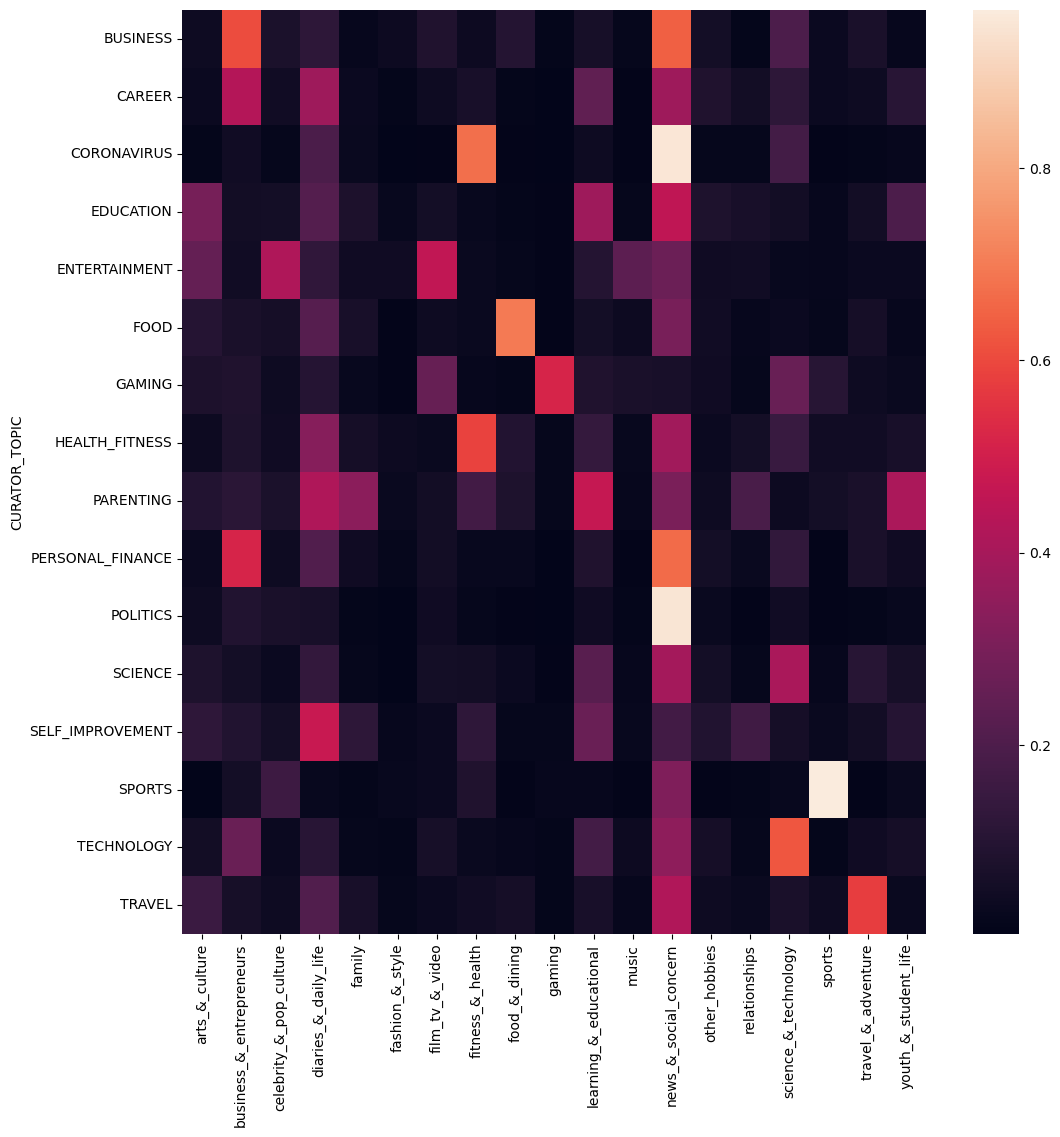

In [9]:

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
sns.heatmap(curator_topics_df.set_index("CURATOR_TOPIC"))

In [10]:
approved.to_csv("approved_with_topic_scores.csv")
publisher_topic_df.to_csv("publishers_with_topic_scores.csv")
curator_topics_df.to_csv("curator_topics_with_topic_scores.csv")

I copied these to `s3://pocket-data-learning/scratch/hackweek-topics/`